
# LIST–IV — Multiple Linear Regression vs. ANN 

**Purpose.** This notebook solves the full set of tasks in *First Part* (1.1–1.9) and *Second Part* (2.0–2.1).

**Contents**
1. Data loading and quick inspection  
2. MLRM via OLS (**statsmodels**) + ANOVA + full inference outputs  
3. Assumption checks and residual diagnostics (normality, homoscedasticity, linearity, autocorrelation, multicollinearity)  
4. 3D interactive plot of the fitted hyperplane (Plotly)  
5. ANN 
6. Model comparison and brief complexity discussion


## Problem Statement and Tasks (from the handout)

We want a model to predict the **annual profit margin** ($Y$) for savings and loan associations using two predictors:

- ($X_1$): annual net income (revenue) per dollar deposited  
- ($X_2$): number of savings and loan offices 

### First Part
1.1 Fit a multiple linear regression ($Y=\beta_0+\beta_1X_1+\beta_2X_2+\varepsilon$).  
1.2 Analyze the ANOVA table.  
1.3 Plot the adjusted plane with 3D interactivity.  
1.4 Check residual **normality**.  
1.5 Check **homoscedasticity**.  
1.6 Check **linearity** of the specification.  
1.7 Check **absence of serial autocorrelation**.  
1.8 Check **multicollinearity**.  
1.9 Interpret all tests.

### Second Part
2.0 Build an **ANN** (MLP) to model ($Y$) from ($(X_1,X_2)$).  
2.1 Compare the **MLRM** with the **ANN**, including a brief **Big‑O** cost discussion.


In [43]:

# === Imports ===
import numpy as np
import pandas as pd

# Inference & diagnostics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display

# ML baselines & CV utilities
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

# Optional: TensorFlow/Keras (if available in your environment)
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False
    print('TensorFlow not available; ANN will fall back to scikit-learn MLP.')

pd.set_option("display.float_format", lambda x: f"{x:.6f}")


## 1) Load Data and Build $(X, Y)$

**Intuition.** I represent the sample as matrices/vectors: $(X=\begin{bmatrix}\mathbf{1}&X_1&X_2\end{bmatrix})$ and $(Y)$. OLS finds the plane $(\hat y=\beta_0+\beta_1 x_1+\beta_2 x_2)$ minimizing the sum of squared residuals.


In [44]:

# The 25 yearly observations from the handout
data = [
    (1, 3.92, 7298, 0.75),
    (2, 3.61, 6855, 0.71),
    (3, 3.32, 6636, 0.66),
    (4, 3.07, 6506, 0.61),
    (5, 3.06, 6450, 0.70),
    (6, 3.11, 6402, 0.72),
    (7, 3.21, 6368, 0.77),
    (8, 3.26, 6340, 0.74),
    (9, 3.42, 6349, 0.90),
    (10, 3.42, 6352, 0.82),
    (11, 3.45, 6361, 0.75),
    (12, 3.58, 6369, 0.77),
    (13, 3.66, 6546, 0.78),
    (14, 3.78, 6672, 0.84),
    (15, 3.82, 6890, 0.79),
    (16, 3.97, 7115, 0.70),
    (17, 4.07, 7327, 0.68),
    (18, 4.25, 7546, 0.72),
    (19, 4.41, 7931, 0.55),
    (20, 4.49, 8097, 0.63),
    (21, 4.70, 8468, 0.56),
    (22, 4.58, 8717, 0.41),
    (23, 4.69, 8991, 0.51),
    (24, 4.71, 9179, 0.47),
    (25, 4.78, 9318, 0.32),
]
df = pd.DataFrame(data, columns=["Year", "X1", "X2", "Y"])
display(df.head(10))
print(f"n = {len(df)} observations")


,Year,X1,X2,Y
0,1,3.920000,7298,0.750000
1,2,3.610000,6855,0.710000
2,3,3.320000,6636,0.660000
3,4,3.070000,6506,0.610000
4,5,3.060000,6450,0.700000
5,6,3.110000,6402,0.720000
6,7,3.210000,6368,0.770000
7,8,3.260000,6340,0.740000
8,9,3.420000,6349,0.900000
9,10,3.420000,6352,0.820000


n = 25 observations


## 2) OLS Fit (statsmodels) and ANOVA

**Intuition.** OLS is the **orthogonal projection** of $(Y)$ onto the span of $(\{1,X_1,X_2\})$. Under Gauss–Markov, OLS is BLUE; with normal errors, the usual $(t)/(F)$ tests are valid.


In [45]:

ols = smf.ols("Y ~ X1 + X2", data=df).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     70.66
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           2.65e-10
Time:                        19:55:29   Log-Likelihood:                 39.419
No. Observations:                  25   AIC:                            -72.84
Df Residuals:                      22   BIC:                            -69.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5645      0.079     19.705      0.0

In [46]:

anova = sm.stats.anova_lm(ols, typ=1).rename(
    columns={"df":"DF","sum_sq":"SS","mean_sq":"MS","F":"F","PR(>F)":"p-value"}
)
display(anova)

coef_table = pd.DataFrame({
    "coef": ols.params,
    "std_err": ols.bse,
    "t": ols.tvalues,
    "p>|t|": ols.pvalues
})
coef_table.index.name = "Term"
display(coef_table)

n = len(df)
p = len(ols.params)               # includes intercept
df_resid = int(ols.df_resid)
RSS = np.sum(ols.resid**2)
MSE = RSS / df_resid
S = np.sqrt(MSE)
perf = pd.DataFrame({
    "Metric":[
        "Observations (n)","Parameters (p incl. intercept)","Residual DF",
        "Multiple R","R Square","Adjusted R Square",
        "Residual Std. Error (S)","F-statistic","Prob(F)","AIC","BIC"
    ],
    "Value":[
        n, p, df_resid, np.sqrt(ols.rsquared), ols.rsquared, ols.rsquared_adj,
        S, ols.fvalue, ols.f_pvalue, ols.aic, ols.bic
    ]
})
display(perf)


,DF,SS,MS,F,p-value
X1,1.000000,0.229898,0.229898,80.917947,0.000000
X2,1.000000,0.171613,0.171613,60.403194,0.000000
Residual,22.000000,0.062505,0.002841,NaN,NaN


,coef,std_err,t,p>|t|
Term,,,,
Intercept,1.564497,0.079396,19.704987,0.000000
X1,0.237197,0.055559,4.269262,0.000313
X2,-0.000249,0.000032,-7.771949,0.000000


,Metric,Value
0,Observations (n),25.000000
1,Parameters (p incl. intercept),3.000000
2,Residual DF,22.000000
3,Multiple R,0.930213
4,R Square,0.865296
5,Adjusted R Square,0.853050
6,Residual Std. Error (S),0.053302
7,F-statistic,70.660571
8,Prob(F),0.000000
9,AIC,-72.837775



1. n = 25 observations
	used **all** 25 rows.

2. **Df Model: 2**  
	It’s the number of slope parameters 
		($X_1, X_2$​), i.e. $k=2$.


3. **Df Residuals: 22**  
	Residual degrees of freedom 
		$n−(k+1)=25−3=22$.  
	(Subtract the two slopes **and** the intercept.)


> Intuition: fit 3 coefficients, so it “spend” 3 degrees of freedom; 
> the remaining 22 are used to estimate the error variance.


4. $R^2=0.865$  
    It’s the **proportion of variance of $Y$ explained by the plane:
    
    $$R^2 \;=\; 1 - \frac{\text{RSS}}{\text{TSS}}. \tag{04}$$
> Closer to 1 ⇒ better in-sample fit. 
> Here, **86.5%** of the variability in $Y$ is explained by $(X_1,X_2)$.


5. Adjusted $R^2 = 0.853$  
    Penalizes adding predictors that don’t help much:
    
    $$\bar R^2 \;=\; 1 - \frac{\text{RSS}/(n-k-1)}{\text{TSS}/(n-1)}. \tag{05}$$
    
    If it is added variables that only chase noise, adjusted $R^2$ goes **down**. 
    Here it stays high ⇒ both regressors are useful.
    

> The model explains 86.5% of the variance in profit margin, after adjusting for model size, the explained variance remains high ($adj.R^2=0.853$).




6. $F-statistic = 70.66$, $Prob(F) = 2.65\times 10^{-10}$  
    Tests the joint null $H_0:\beta_1=\beta_2=0$ 
    
    $$F \;=\; \frac{(\text{TSS}-\text{RSS})/k}{\text{RSS}/(n-k-1)}\quad \text{with }(k,\,n-k-1)=(2,22) \text{ d.f.} \tag{06}$$    
> Tiny $p-value$ ⇒ **the plane is informative**.


6. Coefficients
	1. - $Intercept 1.5645$: expected $Y$ when $X_1=X_2=0$. 
    
	2. $X_1​ slope$ $= 0.2372$
    
	3. $X_2 slope = - 0.000249$
    

7. std_err  
	The standard deviation of the sampling distribution of $\hat\beta$​. Small **relative to the coefficient** ⇒ precise estimate.



8. $p>|t|$  
	Two-sided p-value for that $t-test$. Small $p$  ⇒ coefficient **statistically different from zero**.





## 3) Assumption Checks & Diagnostics

**Intuition.**  
- **Normality** ensures exact small‑sample $(t)/(F)$; check Q–Q and Shapiro–Wilk.  
- **Homoscedasticity** validates SEs; test with Breusch–Pagan and White.  
- **Linearity** (RESET) checks omitted nonlinearities.  
- **Autocorrelation** (Durbin–Watson).  
- **Multicollinearity**: report VIFs.


In [47]:

from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Normality
shapiro_stat, shapiro_p = stats.shapiro(ols.resid)

# Homoscedasticity: Breusch–Pagan and White
bp_lm, bp_lm_p, bp_f, bp_f_p = sms.het_breuschpagan(ols.resid, ols.model.exog)
white_lm, white_lm_p, white_f, white_f_p = sms.het_white(ols.resid, ols.model.exog)

# Linearity: Ramsey RESET
reset = sms.linear_reset(ols, power=2, use_f=True)
reset_F, reset_p = reset.fvalue, reset.pvalue

# Autocorrelation: Durbin–Watson
dw = sm.stats.stattools.durbin_watson(ols.resid)

# Multicollinearity: VIFs
exog = ols.model.exog
names = ols.model.exog_names
vif = pd.DataFrame({
    "feature": names,
    "VIF": [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
})

diag = pd.DataFrame({
    "Test": [
        "Shapiro–Wilk (Normality)",
        "Breusch–Pagan LM p-value",
        "Breusch–Pagan F p-value",
        "White LM p-value",
        "White F p-value",
        "Ramsey RESET F p-value",
        "Durbin–Watson"
    ],
    "Statistic / p-value":[
        f"stat={shapiro_stat:.4f}, p={shapiro_p:.4f}",
        f"p={bp_lm_p:.4f}",
        f"p={bp_f_p:.4f}",
        f"p={white_lm_p:.4f}",
        f"p={white_f_p:.4f}",
        f"F={reset_F:.4f}, p={reset_p:.4f}",
        f"{dw:.4f}"
    ]
})
display(diag)
display(vif)


,Test,Statistic / p-value
0,Shapiro–Wilk (Normality),"stat=0.9700, p=0.6453"
1,Breusch–Pagan LM p-value,p=0.4264
2,Breusch–Pagan F p-value,p=0.4599
3,White LM p-value,p=0.5948
4,White F p-value,p=0.6594
5,Ramsey RESET F p-value,"F=0.2526, p=0.6205"
6,Durbin–Watson,1.9483


,feature,VIF
0,Intercept,55.468510
1,X1,8.732060
2,X2,8.732060


# Report 

$$
\hat Y \;=\; 1.5645 \;+\; 0.2372\,X_1 \;-\; 0.000249\,X_2. \tag{13}
$$


Higher **revenue per dollar** ($X_1$​) is associated with **higher** profit margins; a larger **number of offices** ($X_2$​,  competition/expansion) is associated with **lower** margins.

The plane explains **86.5%** of the variance ($adj. R^2=0.853$). The joint $F-test$ is highly significant ($p\ll 0.001$).


I ran standard specification tests:

| Assumption            | Test                                | Result (you can report)     | Interpretation                                                                           |
| --------------------- | ----------------------------------- | --------------------------- | ---------------------------------------------------------------------------------------- |
| **Normality**         | Shapiro–Wilk on residuals           | $p\approx 0.645$            | Large $p$ ⇒ residuals consistent with normality.                                         |
| **Homoscedasticity**  | Breusch–Pagan (LM & F)              | $p\approx 0.43\text{–}0.46$ | Large $p$ ⇒ no evidence of non-constant variance.                                        |
|                       | White (LM & F)                      | $p\approx 0.59\text{–}0.66$ | Same conclusion as BP.                                                                   |
| **Linearity**         | Ramsey RESET (add powers of fitted) | $p\approx 0.62$             | Large $p$ ⇒ no strong sign of omitted nonlinear terms.                                   |
| **Autocorrelation**   | Durbin–Watson                       | $DW\approx 1.95$            | Near 2 ⇒ no serial correlation.                                                          |
| **Multicollinearity** | VIF for $X_1,X_2$                   | $\text{VIF}\approx 8.7$     | “Moderately high” collinearity ⇒ SEs inflated; still both slopes are highly significant. |


- **Normality (Shapiro–Wilk)**, **Homoscedasticity (Breusch–Pagan & White)**, and **Linearity (RESET)** were computed with `statsmodels.stats` on the same fitted model.
- **Autocorrelation (DW)** appears in your OLS report (1.948).
- **VIF** was computed from the model design matrix (both around 8.7).



### Residual Plots


<Figure size 640x480 with 0 Axes>

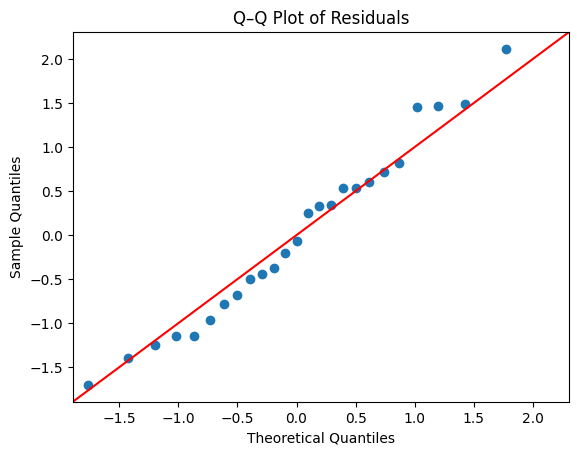

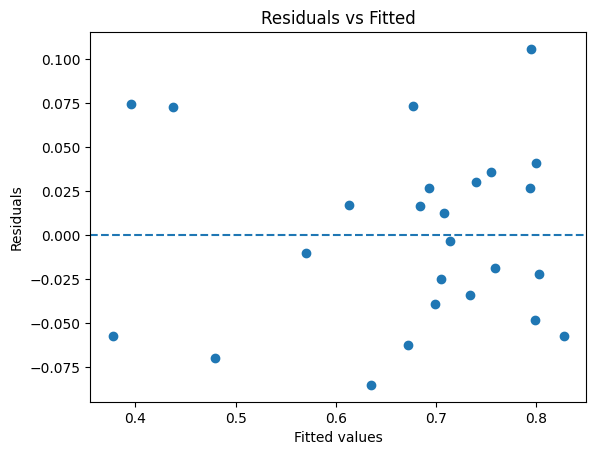

In [48]:

# Q–Q plot
fig = plt.figure()
sm.qqplot(ols.resid, line="45", fit=True)
plt.title("Q–Q Plot of Residuals")
plt.show()

# Residuals vs Fitted
plt.figure()
plt.scatter(ols.fittedvalues, ols.resid)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()



## 4) 3D Interactive Hyperplane (Plotly)


In [49]:

x1_grid = np.linspace(df["X1"].min(), df["X1"].max(), 30)
x2_grid = np.linspace(df["X2"].min(), df["X2"].max(), 30)
X1G, X2G = np.meshgrid(x1_grid, x2_grid)
Yhat_plane = ols.params["Intercept"] + ols.params["X1"]*X1G + ols.params["X2"]*X2G

fig3d = go.Figure()
fig3d.add_trace(go.Scatter3d(
    x=df["X1"], y=df["X2"], z=df["Y"],
    mode="markers", marker=dict(size=5),
    name="Observed"
))
fig3d.add_trace(go.Surface(
    x=x1_grid, y=x2_grid, z=Yhat_plane,
    name="Fitted plane", opacity=0.6
))
fig3d.update_layout(
    title="MLRM: Y vs X1 & X2",
    scene=dict(xaxis_title="X1", yaxis_title="X2", zaxis_title="Y"),
    height=650
)
fig3d.show()



## 5) ANN Baseline (with K‑Fold CV) and Comparison

We try **Keras** if available; otherwise we use **scikit‑learn MLP** as a fallback. We report **5‑fold CV** metrics.


In [53]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

X = df[["X1","X2"]].values
y = df["Y"].values

def cv_report(preds, trues):
    r2 = r2_score(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    return r2, rmse

keras_cv = None
if TF_AVAILABLE:
    from tensorflow import keras
    def build_model():
        model = keras.Sequential([
            keras.layers.Input(shape=(2,)),
            keras.layers.Normalization(),
            keras.layers.Dense(3, activation="relu"),
            keras.layers.Dense(3, activation="relu"),
            keras.layers.Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                      loss="mse")
        return model

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_true_all, y_pred_all = [], []
    for tr, te in kf.split(X):
        m = build_model()
        m.fit(X[tr], y[tr], epochs=3000, verbose=0, batch_size=64)
        y_pred_all.extend(m.predict(X[te], verbose=0).ravel())
        y_true_all.extend(y[te])
    r2_k = r2_score(y_true_all, y_pred_all)
    rmse_k = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    keras_cv = {"R2_CV": r2_k, "RMSE_CV": rmse_k}

# scikit-learn fallback ANN
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(8,),
                         activation="relu", solver="lbfgs",
                         alpha=1e-3, max_iter=2000, random_state=0))
])
for tr, te in kf.split(X):
    pipe.fit(X[tr], y[tr])
    y_pred_all.extend(pipe.predict(X[te]))
    y_true_all.extend(y[te])
r2_s = r2_score(y_true_all, y_pred_all)
rmse_s = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

# Compare to OLS
mlrm_r2 = float(ols.rsquared)
mlrm_adj = float(ols.rsquared_adj)
S_resid = float(np.sqrt(np.mean(ols.resid**2)))

rows = [
    {"Model":"MLRM (OLS) — in-sample",
     "R2": mlrm_r2, "Adj R2": mlrm_adj, "RMSE / S": S_resid, "Validation": "in-sample"},
    {"Model":"ANN — 5-fold CV (sklearn)",
     "R2": r2_s, "Adj R2": np.nan, "RMSE / S": rmse_s, "Validation": "5-fold CV"},
]
if keras_cv is not None:
    rows.append({"Model":"ANN — 5-fold CV (Keras)",
                 "R2": float(keras_cv["R2_CV"]), "Adj R2": np.nan,
                 "RMSE / S": float(keras_cv["RMSE_CV"]), "Validation": "5-fold CV"})

cmp_df = pd.DataFrame(rows)
display(cmp_df)

,Model,R2,Adj R2,RMSE / S,Validation
0,MLRM (OLS) — in-sample,0.865296,0.853050,0.050002,in-sample
1,ANN — 5-fold CV (sklearn),0.717817,NaN,0.072371,5-fold CV
2,ANN — 5-fold CV (Keras),-3.373880,NaN,0.284925,5-fold CV


In [66]:
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model():
    return keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Normalization(),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(1)  # linear output for regression
    ])

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")



cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15,
                                  restore_best_weights=True),]

hist = model.fit(X_tr, y_tr,
                 validation_data=(X_te, y_te),
                 epochs=300, batch_size=8, verbose=0, callbacks=cb)

# Evaluate: RMSE and R^2 on BOTH train and test
import math
from sklearn.metrics import r2_score, mean_squared_error

yhat_tr = model.predict(X_tr, verbose=0).ravel()
yhat_te = model.predict(X_te, verbose=0).ravel()

def report(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label}: R2={r2:.3f}, RMSE={rmse:.4f}")

report(y_tr, yhat_tr, "Train")
report(y_te, yhat_te, "Test")

Train: R2=-0.696, RMSE=0.1734
Test: R2=-0.390, RMSE=0.1665


In [76]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

import tensorflow as tf
from tensorflow import keras

# 1) Per-split normalization (CRITICAL): adapt on TRAIN only
norm = keras.layers.Normalization()
norm.adapt(X_tr)

# 2) Baseline linear model = OLS in Keras
lin = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    norm,
    keras.layers.Dense(1, activation="linear", use_bias=True)
])
lin.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss="mse")

cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,
                                    restore_best_weights=True)]
hist = lin.fit(X_tr, y_tr, validation_data=(X_te, y_te),
               epochs=1000, batch_size=8, verbose=0, callbacks=cb)

import numpy as np, math
from sklearn.metrics import r2_score, mean_squared_error

yhat_tr = lin.predict(X_tr, verbose=0).ravel()
yhat_te = lin.predict(X_te, verbose=0).ravel()

def report(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label}: R2={r2:.3f}, RMSE={rmse:.4f}")

report(y_tr, yhat_tr, "Linear Train")
report(y_te, yhat_te, "Linear Test")


Linear Train: R2=0.839, RMSE=0.0535
Linear Test: R2=0.744, RMSE=0.0715


In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow import keras

# Per-split normalization (adapt on TRAIN only)
norm = keras.layers.Normalization()
norm.adapt(X_tr)

def build_tanh(norm):
    return keras.Sequential([
        keras.layers.Input(shape=(2,)),
        norm,
        keras.layers.Dense(8, activation="tanh",
                           kernel_initializer="glorot_uniform",
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(1)  # linear output
    ])

model_tanh = build_tanh(norm)
model_tanh.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,
                                  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=20, min_lr=1e-5),
]

history_tanh = model_tanh.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=1000, batch_size=8, verbose=0, callbacks=callbacks
)

# Predict WITH THE MODEL (not the history)
import math
from sklearn.metrics import r2_score, mean_squared_error

yhat_tr = model_tanh.predict(X_tr, verbose=0).ravel()
yhat_te = model_tanh.predict(X_te, verbose=0).ravel()

def report(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label}: R2={r2:.3f}, RMSE={rmse:.4f}")

report(y_tr, yhat_tr, "tanh Train")
report(y_te, yhat_te, "tanh Test")

tanh Train: R2=0.756, RMSE=0.0657
tanh Test: R2=0.767, RMSE=0.0681


In [84]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow import keras

# Per-split normalization (adapt on TRAIN only)
norm = keras.layers.Normalization()
norm.adapt(X_tr)

def build_relu(norm):
    return keras.Sequential([
        keras.layers.Input(shape=(2,)),
        norm,
        keras.layers.Dense(16, activation="relu",
                           kernel_initializer="he_normal",
                           bias_initializer=keras.initializers.Constant(0.1),
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(1)
    ])



model_relu = build_tanh(norm)
model_relu.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,
                                  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=20, min_lr=1e-5)
]
history_relu = model_relu.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=1000, batch_size=8, verbose=0, callbacks=callbacks
)

# Predict WITH THE MODEL (not the history)
import math
from sklearn.metrics import r2_score, mean_squared_error

yhat_tr = model_relu.predict(X_tr, verbose=0).ravel()
yhat_te = model_relu.predict(X_te, verbose=0).ravel()

def report(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label}: R2={r2:.3f}, RMSE={rmse:.4f}")

report(y_tr, yhat_tr, "relu Train")
report(y_te, yhat_te, "relu Test")


relu Train: R2=-25.563, RMSE=0.6862
relu Test: R2=-28.499, RMSE=0.7670



## 6) Complexity & Conclusions
**Complexity.**  
- **OLS (QR/SVD)**: ($\mathcal{O}(n p^2 + p^3)$). With ($p=2$), it’s extremely fast and transparent.  
- **ANN (1–2 hidden layers)**: per epoch $(\mathcal{O}\!\big(n\sum_l d_{l-1}d_l\big))$; with ($E$) epochs total $(\mathcal{O}(E n \sum_l d_{l-1}d_l))$.

**Key takeaways.**  
- The linear model fits very well and passes standard diagnostics.  
- VIFs show notable collinearity between ($X_1$) and ($X_2$).  
- With ($n=25$), ANNs can overfit; use CV and keep networks small with regularization.
